In [106]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

import olympus
from olympus.scalarizers import Scalarizer
from olympus.datasets import Dataset

In [112]:
def num_eval_to_x(res, pd, dl):
    num_evals = []
    for r in res:
        good_evals = r.index[(r['particle_diameter']<=np.log10(pd))&(r['drug_loading']>=dl)].tolist()
        if not good_evals == []:
            num_evals.append(np.amin(good_evals)+1)
        else:
            num_evals.append(r.shape[0]) # budget evals
    return num_evals, np.mean(num_evals), np.median(num_evals), np.std(num_evals)

In [123]:
# load resulsts
raw_res_rand = pickle.load(open('../results/results_random.pkl', 'rb'))
raw_res_bo   = pickle.load(open('../results/results_botorch.pkl', 'rb'))
raw_res_grid = pickle.load(open('../results/results_grid.pkl', 'rb'))
raw_res_bo_5 = pickle.load(open('../results/results_botorch_5_init.pkl', 'rb'))

print(len(raw_res_rand))
print(len(raw_res_bo))
print(len(raw_res_grid))
print(len(raw_res_bo_5))

dataset = Dataset('lnp')

scalarizer = Scalarizer(
        kind='Hypervolume',
        value_space=dataset.value_space,
        goals=['min', 'max'],
    )


def unpack_results(res):
    
    num_iter = res[0].shape[0]
    new_dfs = []
    
    for ix in range(len(res)):
        r = res[ix]
        scal = scalarizer.scalarize(r.loc[:, ['particle_diameter', 'drug_loading']].values)
        trace_best_ix = [np.argmin(scal[:i+1]) for i in range(len(scal))]
        trace0 = [r.loc[i, 'particle_diameter'] for i in trace_best_ix]
        trace1 = [r.loc[i, 'drug_loading'] for i in trace_best_ix]
        r['iter'] = np.arange(r.shape[0])+1
        r['repeat'] = ix
        r['best_particle_diameter'] = 10**np.array(trace0)
        r['best_drug_loading'] = trace1
        new_dfs.append(r)
        
    return pd.concat(new_dfs, ignore_index=True)
        
        
res_rand = unpack_results(raw_res_rand)
res_bo = unpack_results(raw_res_bo)
res_grid = unpack_results(raw_res_grid)
res_bo_5 = unpack_results(raw_res_bo_5)


20
16
20
20


In [124]:
pdi = 15
dl = 0.19
num_evals_rand, mean_rand, med_rand, _ = num_eval_to_x(raw_res_rand, pdi, dl)
num_evals_bo, mean_bo, med_bo, _ = num_eval_to_x(raw_res_bo, pdi, dl)
num_evals_grid, mean_grid, med_grid, _ = num_eval_to_x(raw_res_grid, pdi, dl)
num_evals_bo_5, mean_bo_5, med_bo_5, _ = num_eval_to_x(raw_res_bo_5, pdi, dl)

num_evals_list = []
for n in num_evals_rand:
    num_evals_list.append({'method': 'rand', 'num_evals': n})
for n in num_evals_grid:
    num_evals_list.append({'method': 'grid', 'num_evals': n})
for n in num_evals_bo:
    num_evals_list.append({'method': 'bo', 'num_evals': n})
for n in num_evals_bo_5:
    num_evals_list.append({'method': 'bo_5', 'num_evals': n})


num_evals = pd.DataFrame(num_evals_list)

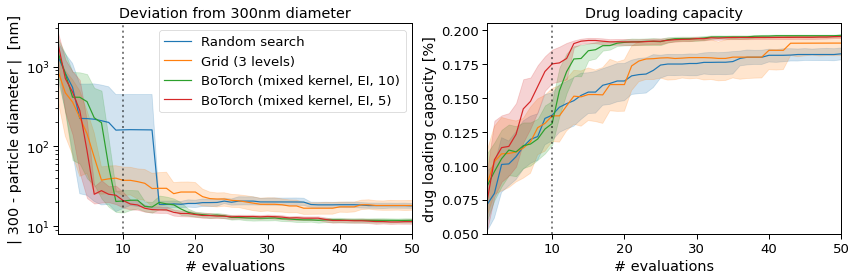

In [128]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(data=res_rand, x='iter', y='best_particle_diameter', ax=ax0, label='Random search')
sns.lineplot(data=res_rand, x='iter', y='best_drug_loading', ax=ax1)

sns.lineplot(data=res_grid, x='iter', y='best_particle_diameter', ax=ax0, label='Grid (3 levels)')
sns.lineplot(data=res_grid, x='iter', y='best_drug_loading', ax=ax1)

sns.lineplot(data=res_bo, x='iter', y='best_particle_diameter', ax=ax0, label='BoTorch (mixed kernel, EI, 10)')
sns.lineplot(data=res_bo, x='iter', y='best_drug_loading', ax=ax1)

sns.lineplot(data=res_bo_5, x='iter', y='best_particle_diameter', ax=ax0, label='BoTorch (mixed kernel, EI, 5)')
sns.lineplot(data=res_bo_5, x='iter', y='best_drug_loading', ax=ax1)

# ax0.set_yscale('log')

ax0.set_title('Deviation from 300nm diameter')
ax1.set_title('Drug loading capacity')

# ax0.set_ylim(0.9, 2.6)
ax0.set_yscale('log')
ax1.set_ylim(0.05, 0.205)
ax0.set_xlim(1, 50)
ax1.set_xlim(1, 50)

ax0.set_xlabel('# evaluations')
ax1.set_xlabel('# evaluations')

ax0.set_ylabel('| 300 - particle diameter |  [nm]')
ax1.set_ylabel('drug loading capacity [%]')

ax0.axvline(10, lw=2, ls=':', alpha=0.5, c='k')
ax1.axvline(10, lw=2, ls=':', alpha=0.5, c='k')



plt.tight_layout()
plt.savefig('traces_two_objs.png', dpi=400)

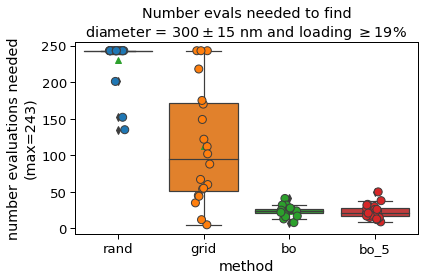

In [134]:
fig, ax0 = plt.subplots(1, 1, figsize=(6, 4))

sns.boxplot(data=num_evals, x='method', y='num_evals', showmeans=True)
sns.stripplot(data=num_evals, x='method', y='num_evals', edgecolor='gray', linewidth=1, size=8)

ax0.set_ylabel('number evaluations needed\n(max=243)')
ax0.set_xlabel('method')

ax0.set_title(f'Number evals needed to find\n'+f'diameter = $300\pm15$ nm'+f' and loading $\geq 19\%$')

plt.tight_layout()
plt.savefig('num_evals_needed_two_obj.png', dpi=400)

In [127]:
print(mean_bo_5, mean_bo, mean_grid, mean_rand)
print(med_bo_5, med_bo, med_grid, med_rand)

23.45 23.8125 112.1 230.95
21.5 24.5 95.0 243.0


In [121]:
112.1/23.81

4.7081058378832426

In [91]:
raw_res_bo[0]

,drug_input,solid_lipid,solid_lipid_input,liquid_lipid_input,surfractant_input,particle_diameter,drug_loading,iter,repeat,best_particle_diameter,best_drug_loading
0,34.19400024015158,Compritol_888,82.108943025511,47.512779055891876,0.008069409997176466,1.074144,0.138553,1,0,11.861617,0.138553
1,12.079293821106138,Stearic_acid,103.02196766826964,45.215819329172234,0.00837963519939755,3.625747,0.034591,2,0,11.861617,0.138553
2,33.28555378278901,Glyceryl_monostearate,116.00558931476175,16.302744075208636,0.0067167804614864405,3.384647,0.057812,3,0,11.861617,0.138553
3,13.964632971409605,Compritol_888,119.17448638948498,23.347796125858117,2.1276872140251203e-05,0.813408,0.011822,4,0,11.861617,0.138553
4,17.779211012436804,Glyceryl_monostearate,91.68078244843376,23.764862627605616,0.0075547385742623634,3.498508,0.027671,5,0,11.861617,0.138553
5,22.990928055870885,Compritol_888,116.87710755174021,26.97804832378675,0.008538444679759359,1.637103,0.088875,6,0,11.861617,0.138553
6,24.973713780050446,Stearic_acid,111.1911688355856,40.31352710547141,0.0062599446794203975,3.602752,0.082224,7,0,11.861617,0.138553
7,18.983477944866024,Glyceryl_monostearate,97.18571601404403,44.612206298423274,0.00040177577735367676,1.736507,0.026142,8,0,11.861617,0.138553
8,32.13342429673405,Glyceryl_monostearate,107.60359372855267,35.643280955582114,0.009586555754648179,3.474097,0.063846,9,0,11.861617,0.138553
9,13.520729365583417,Compritol_888,116.84605186737348,25.146346906105848,0.008792714180064696,1.702363,0.044184,10,0,11.861617,0.138553
